In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("../data/raw/210119_en_deter_preprocessed.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

In [3]:
df.shape

(39835, 10)

In [4]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

In [5]:
# distribution starting from 1990
df.loc[df["year"] >= 1990, "year"].value_counts()

2017.0    3135
2016.0    2383
2018.0    2307
2020.0    2057
2019.0    1969
2010.0    1843
2013.0    1827
2015.0    1662
2012.0    1499
2009.0    1473
2011.0    1380
2014.0    1156
2000.0     917
1999.0     895
1998.0     865
2006.0     857
2001.0     842
2007.0     837
2008.0     775
2003.0     745
2002.0     744
2005.0     705
2004.0     580
1996.0     501
1997.0     481
1995.0     437
1991.0     424
1990.0     395
1993.0     359
1994.0     344
1992.0     342
2021.0       1
Name: year, dtype: int64

In [6]:
# preparing data for visualization
dist = (
    df["year"]
     .value_counts()
     .to_frame()
     .reset_index()
     .rename(columns={"year": "counts", "index": "year"})
)

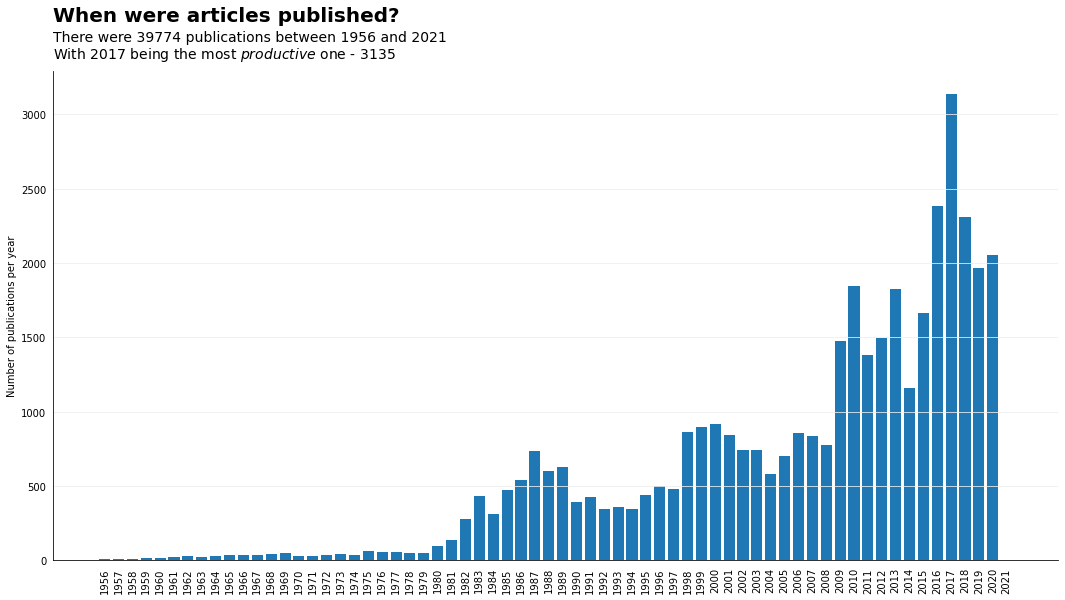

In [7]:
# first viz
fig, ax = plt.subplots(1, 1, figsize=(18,9))

# removing 1900 outlier
dist = dist.loc[dist["year"] > 1900]
ax.bar(dist["year"], dist["counts"], label="counts", tick_label=dist["year"].astype(int))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.yaxis.grid(True, color='#EEEEEE')

plt.ylabel("Number of publications per year")
plt.xticks(rotation=90)

fig.suptitle("When were articles published?", fontsize=20, fontweight='bold',x=0.125,ha='left')
fig.text(0.125,0.927,f"There were {dist['counts'].sum()} publications between {dist['year'].astype(int).min()} and {dist['year'].astype(int).max()}",fontsize=14)
fig.text(0.125,0.9,f"With {dist.iloc[0, 0].astype(int)} being the most $productive$ one - {dist.iloc[0, 1].astype(int)}",fontsize=14)
plt.savefig("../reports/figures/1.0-docs total.png", dpi=300, bbox_inches="tight", pad_inches=0.3, transparent=False)
plt.show()

In [8]:
# the same but for publications with full text available
has_text = df.loc[~(df["fulltext"].isna() | df["fulltext"].eq("") | (df["fulltext"].str.contains("^Not available.")))]

has_text_dist = (
    has_text["year"]
     .value_counts()
     .to_frame()
     .reset_index()
     .rename(columns={"year": "counts", "index": "year"})
)

In [9]:
annotations = pd.merge(dist, has_text_dist, how="left", on="year", suffixes=("_all", "_fulltext"))
annotations["perc"] = (annotations["counts_fulltext"].fillna(0) / annotations["counts_all"] * 100).astype(int).astype(str) + "%"
annotations

,year,counts_all,counts_fulltext,perc
0,2017.0,3135,2668.0,85%
1,2016.0,2383,1987.0,83%
2,2018.0,2307,1905.0,82%
3,2020.0,2057,1724.0,83%
4,2019.0,1969,1518.0,77%
...,...,...,...,...
61,1959.0,16,2.0,12%
62,1957.0,9,2.0,22%
63,1958.0,7,1.0,14%
64,1956.0,6,NaN,0%


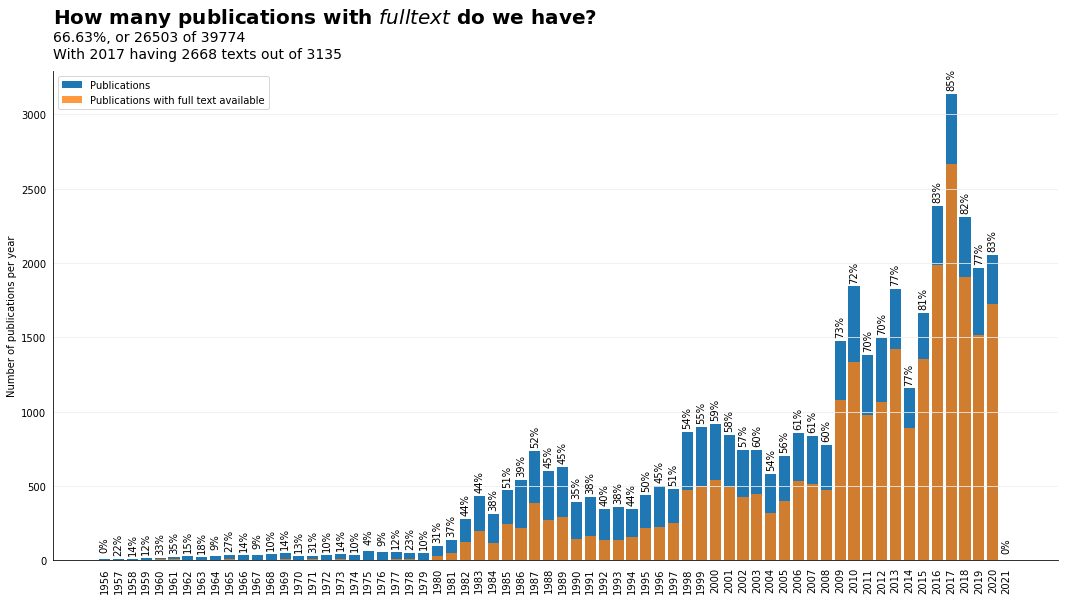

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))

# removing 1900 outlier
dist = dist.loc[dist["year"] > 1900]
ax.bar(dist["year"], dist["counts"], label="Publications", tick_label=dist["year"].astype(int))
ax.bar(has_text_dist["year"], has_text_dist["counts"], label="Publications with full text available", alpha=0.8)

for idx in annotations.index:
    _row = annotations.loc[idx, :]
    ax.annotate(
        _row["perc"],
        xy=(_row["year"], _row["counts_all"] + 100),
        ha="center", va="center", rotation=90
  )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.yaxis.grid(True, color='#EEEEEE')

plt.ylabel("Number of publications per year")
plt.xticks(rotation=90)
plt.legend()

fig.suptitle("How many publications with $fulltext$ do we have?", fontsize=20, fontweight='bold',x=0.125,ha='left')
fig.text(0.125,0.927,f'{(has_text_dist["counts"].sum() / dist["counts"].sum() * 100).round(2)}%, or {has_text_dist["counts"].sum()} of {dist["counts"].sum()}',fontsize=14)
fig.text(0.125,0.9,f"With {dist.iloc[0, 0].astype(int)} having {has_text_dist.iloc[0, 1]} texts out of {dist.iloc[0, 1]}",fontsize=14)
plt.savefig("../reports/figures/1.0-docs with fulltext.png", dpi=300, bbox_inches="tight", pad_inches=0.3, transparent=False)
plt.show()